# Comparative analysis of glyph skeletons from the 15th century
* <u>version: 0.1</u>
* <u>updated: 02.11.2024</u>
* <u>author: Florian Kordon</u>

This interactive notebook contains different tools to analyse and compare character sets from two books. Many tools allow for user-input to configure and/or steer the analysis behavior or to adapt the visualization of the data/results. The development was tested with digital reproductions of the *Catholicon*. 

**Analysis Workflow**
In the following, let's highlight the main workflow components. Details for each component are provided in the respective section.
* (0) Package installation and import
* (1) Data loading
* (2) Intra-stack registration
* (3) Intra-stack clustering
* (4) Matching of clusters
* (5) Comparison of character subgroups
* (6) Comparison of image stacks

**ToDos**
* Add more options for reference selection: image selection, Fréchet mean (OT barycenter), median
* Allow for cluster comparison and matching using alternative cluster centroids: e.g., Fréchet mean
* Add more similarity/distance measures between clusters/substacks
* Statistical test: Are the distances between glyphs in (A) similar to the ones in (B)? Is any noticable difference below a certain significance threshold?

### 0 Package import

In [1]:
# !pip install numpy matplotlib pillow seaborn pandas ipycanvas umap-learn pystackreg hdbscan plotly jupyter ipywidgets jupyterlab_widgets

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from configuration import *
from computation import *
from presentation import *

import ipywidgets as widgets

from pathlib import Path
from scipy.spatial.distance import pdist, cdist
from scipy.stats import wasserstein_distance

from sklearn.manifold import MDS, TSNE, Isomap
from sklearn.decomposition import PCA

## 1 Data loading & visualization
 First, we need to load prediction data from two books that we want to compare. The data is expected to be in the form of probability maps of the character's skeleton and is provided separatly.

#### 1.1 Load glyph skeletons for two books that you want to compare

In [3]:
################ EDIT HERE #################
character = 'h_lowercase'

root_dir_A = Path(r"D:\20_PostDoc\10_Data\10_Incunables\50_Analysis\GW03182 0 Berlin SB") / "skeleton_analysis"
root_dir_B = Path(r"D:\20_PostDoc\10_Data\10_Incunables\50_Analysis\GW03182_Princeton_ScheidL") / "skeleton_analysis"
################ END EDIT ##################

In [4]:
print("Data loading")

print(f"{'(i) Loading skeleton data from storage for book (A)':.>60}")
char_dir_A = root_dir_A.joinpath(character)
pred_A = np.load(char_dir_A.joinpath("pred.npy")).squeeze(1)

print(f"{'(ii) Loading skeleton data from storage for book (B)':.>60}")
char_dir_B = root_dir_B.joinpath(character)
pred_B = np.load(char_dir_B.joinpath("pred.npy")).squeeze(1)

print (u'\u2713', "Done")

Data loading
.........(i) Loading skeleton data from storage for book (A)
........(ii) Loading skeleton data from storage for book (B)
✓ Done


#### 1.2 Visualize image content for the loaded image stacks (A) and (B)

In [5]:
widgets.interact(
    display_images,
    imga_stack=widgets.fixed(pred_A),
    imgb_stack=widgets.fixed(pred_B),
    imga_z=widgets.IntSlider(value=0, min=0, max=pred_A.shape[0] - 1, description="Select image from (A)", style={'description_width': 'initial'}),
    imgb_z=widgets.IntSlider(value=0, min=0, max=pred_B.shape[0] - 1, description="Select image from (B)", style={'description_width': 'initial'}),
    cmap=get_colormap_dropdown('viridis')
);

interactive(children=(IntSlider(value=0, description='Select image from (A)', max=3491, style=SliderStyle(desc…

## 2 Intra-stack registration
The images in each data stack show great diveristy regarding their centering in the image frame (depending on how they were cropped and extracting). Upon prediction it was assured that the scaling across the images for each book stays consistent. 

We start by performing a *registering* of the images within one stack (e.g., all images from the image stack (A)) to a reference image. Upon prediction it was assured that the scaling across the images for each book stays consistent. Therefore, we use a rigid body transformation (translation + rotation).
Let's call this process **intra-stack registration**.

#### 3.1 Reference method and transformation
Choosing the reference image is a critical step since the reference decides how all remaining images in the stack will be transformed.
For now, we can choose between between *mean* (average image for the whole image stack) or *first* (first image).

In [6]:
ref_chooser = widgets.Dropdown(options=['first', 'mean'], value='first', description="Choose reference method:", style={'description_width': 'initial'})
display(ref_chooser)

Dropdown(description='Choose reference method:', options=('first', 'mean'), style=DescriptionStyle(description…

In [7]:
print("Intra-stack registration")

print(f"(i) Performing intra-stack registration for (A) using '{ref_chooser.value}' as reference method.")
registered_A = register_imagestack(pred_A, save_dir=char_dir_A, transformation=3, reg_mode=ref_chooser.value)  # default: RIGID BODY transformation

print(f"(ii) Performing intra-stack registration for (B) using '{ref_chooser.value}' as reference method.")
registered_B = register_imagestack(pred_B, save_dir=char_dir_B, transformation=3, reg_mode=ref_chooser.value)  # default: RIGID BODY transformation

print (u'\u2713', "Done")

Intra-stack registration
(i) Performing intra-stack registration for (A) using 'first' as reference method.
(ii) Performing intra-stack registration for (B) using 'first' as reference method.
✓ Done


#### 3.2 Registration results stack (A)
We can now visualize the registration results for stack (A).

In [8]:
widgets.interact(
    display_registration_results,
    reference_method=widgets.fixed(ref_chooser.value),
    img_stack_unreg=widgets.fixed(pred_A),
    img_stack_reg=widgets.fixed(registered_A),
    img_z=widgets.IntSlider(value=0, min=0, max=pred_A.shape[0] - 1, description="Select moving image from (A)", style={'description_width': 'initial'}),
    cmap_stack=get_colormap_dropdown('viridis'),
    cmap_diff=get_colormap_dropdown('coolwarm', description="Choose colormap for diff. image:")
);

interactive(children=(IntSlider(value=0, description='Select moving image from (A)', max=3491, style=SliderSty…

#### 3.3 Registration results stack (B)
Similarly, we can visualize the registration quality for image stack (B).

In [9]:
widgets.interact(
    display_registration_results,
    reference_method=widgets.fixed(ref_chooser.value),
    img_stack_unreg=widgets.fixed(pred_B),
    img_stack_reg=widgets.fixed(registered_B),
    img_z=widgets.IntSlider(value=0, min=0, max=pred_B.shape[0] - 1, description="Select moving image from (B)", style={'description_width': 'initial'}),
    cmap_stack=get_colormap_dropdown('viridis'),
    cmap_diff=get_colormap_dropdown('coolwarm', description="Choose colormap for diff. image:")
);

interactive(children=(IntSlider(value=0, description='Select moving image from (B)', max=11832, style=SliderSt…

## 3 Intra-stack clustering
We now want to take the registered images and perform a feature-based clustering to identify similar subgroups within each image stack. This process involves a low-dimensional feature embedding (currently UMAP) and a density-based clustering (currently HDBSCAN).

#### 3.1 Configuration & execution

In [10]:
embedding_config = dict(
    n_neighbors = 30, # (int) size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved
    min_dist = 0.0,   # (float) effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points
    random_state = 42
)
hdbscan_clustering_config = dict(
    min_samples = 10,       # (int) number of samples in a neighborhood for a point to be considered as a core point
    min_cluster_size = 50   # (int) minimum size of clusters; single linkage splits that contain fewer points than this will be considered points "falling out" of a cluster rather than a cluster splitting into two new clusters
)
kmeans_cluster_config = None

In [11]:
%autoreload 2
print("Intra-stack embeddings")

print(f"{'(i) Creating image embeddings for stack (A) using UMAP':.>60}")
embedding_A = clusterable_embedding_umap(registered_A, embedding_config)

print(f"{'(ii) Creating image embeddings for stack (B) using UMAP':.>60}")
embedding_B = clusterable_embedding_umap(registered_B, embedding_config)

print(f"{'(iii) Performing clustering of the embeddings using HDBSCAN.':.>60}")
cluster_labels_A = clustering_hdbscan(embedding_A, hdbscan_clustering_config)
cluster_labels_sorted_A = uniquify_labels(cluster_labels_A)

print(f"{'(iv) Performing clustering of the embeddings using HDBSCAN.':.>60}")
cluster_labels_B = clustering_hdbscan(embedding_B, hdbscan_clustering_config)
cluster_labels_sorted_B = uniquify_labels(cluster_labels_B)

print (u'\u2713', "Done")

Intra-stack embeddings
......(i) Creating image embeddings for stack (A) using UMAP


c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


.....(ii) Creating image embeddings for stack (B) using UMAP


c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(iii) Performing clustering of the embeddings using HDBSCAN.
.(iv) Performing clustering of the embeddings using HDBSCAN.
✓ Done


c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 3.2 Visualization results stack (A)

In [12]:
widgets.interact(
    cluster_overview,
    img_stack = widgets.fixed(registered_A),
    cluster_labels = widgets.fixed(cluster_labels_A),
    cluster_labels_sorted = widgets.fixed(cluster_labels_sorted_A),
    tgt_num_rows = widgets.fixed(10), 
    cmap=get_colormap_dropdown('inferno')
);

interactive(children=(Dropdown(description='Choose colormap:', index=138, options=('Accent', 'Accent_r', 'Blue…

#### 3.3 Visualization results stack (B)

In [13]:
widgets.interact(
    cluster_overview,
    img_stack = widgets.fixed(registered_B),
    cluster_labels = widgets.fixed(cluster_labels_B),
    cluster_labels_sorted = widgets.fixed(cluster_labels_sorted_B),
    tgt_num_rows = widgets.fixed(10), 
    cmap=get_colormap_dropdown('inferno')
);

interactive(children=(Dropdown(description='Choose colormap:', index=138, options=('Accent', 'Accent_r', 'Blue…

## 4 Matching of clusters between (A) and (B)
Since we perform registration, embedding and clustering separatly for the different image stacks we will obtain different numbers of stack-specific clusters. In other words, cluster 1 for stack (A) does not necessarily correspond to cluster 1 in stack (B).
To allow for subsequenty comparison between character subgroups (aka clusters), we perform several steps to find matching cluster between the stacks (A) and (B):
* We select a registration anchor/reference for each identified cluster for a secondary **intra-cluster** registration. This serves as a fine-tuning step to imrpove the alignment of the images within a cluster.
* We compute cluster centroids that correspond to meaningful representatives for each identified cluster.
* Based on the cluster centroids we compute an *optimal* 1-1 matching using the Hungarian Matching algorithm.
* We provide a interactive graphical way that enables the user to manually connect clusters between (A) and (B) based on their visiual similarity

#### 4.1 Intra-cluster registration

In [14]:
print("Intra-cluster registration & cluster map generation")

print(f"{'(i) Registering clusters for stack (A)':.>50}")
clusters_A = build_cluster_dict(registered_A, cluster_labels_A, cluster_labels_sorted_A, intra_cluster_registration=True, transformation=3, reg_mode=ref_chooser.value)

print(f"{'(ii) Registering clusters for stack (B)':.>50}")
clusters_B = build_cluster_dict(registered_B, cluster_labels_B, cluster_labels_sorted_B, intra_cluster_registration=True, transformation=3, reg_mode=ref_chooser.value)

print (u'\u2713', "Done")

Intra-cluster registration & cluster map generation
............(i) Registering clusters for stack (A)
...........(ii) Registering clusters for stack (B)
✓ Done


#### 4.2 Cluster centroid calculation

In [15]:
print("Cluster Centroid Calculation")

print(f"{'(i) Calculating centroids for stack (A)':.>50}")
cluster_centroids_A = build_centroid_dict(clusters_A, op_centroid='mean')

print(f"{'(ii) Calculating centroids for stack (B)':.>50}")
cluster_centroids_B = build_centroid_dict(clusters_B, op_centroid='mean')

print (u'\u2713', "Done")

Cluster Centroid Calculation
...........(i) Calculating centroids for stack (A)
..........(ii) Calculating centroids for stack (B)
✓ Done


#### 4.3 Automatic matching using the Hungarian Algorithm

Cost-optimal inter-cluster mapping
(i) Inter-cluster registration and Hungarian matching
(ii) Visualization of matching results between (A) and (B)


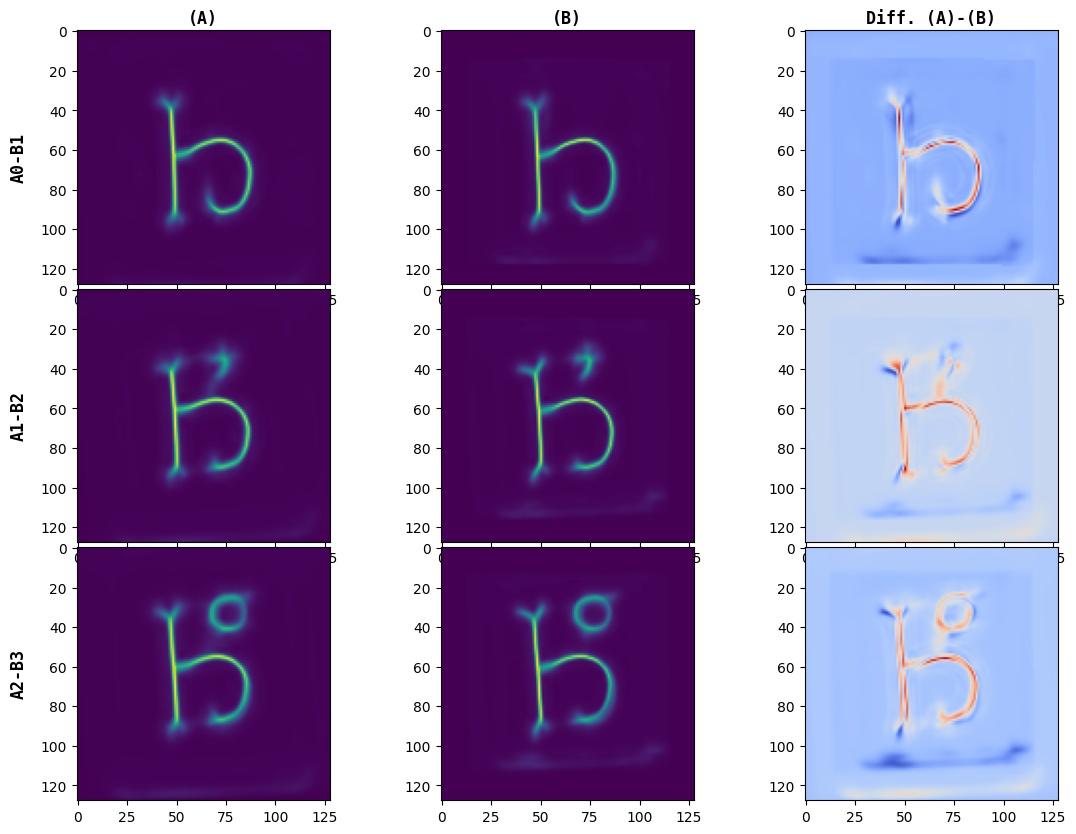

✓ Done


In [16]:
print("Cost-optimal inter-cluster mapping")

print(f"{'(i) Inter-cluster registration and Hungarian matching':.>50}")
matched_pairs, matching_cost, unmatched_A, unmatched_B = hungarian_matching(cluster_centroids_A, cluster_centroids_B, cross_registration=True)

print(f"{'(ii) Visualization of matching results between (A) and (B)':.>50}")
viz_hungarian_cluster_matching(matched_pairs, matching_cost, cluster_centroids_A, cluster_centroids_B, cmap=plt.cm.coolwarm)

print (u'\u2713', "Done")

Below is given a table of the cluster statistics derived from the matching results which shall serve as a guide to select subgroup/cluster pairs for the subsequent analysis. Feel free to account for the matching cost (the lower the better) and the number of images present in the respective clusters.

In [17]:
display_cluster_mappings(dict(matched_pairs), matching_cost, clusters_A, clusters_B)

Stack A Cluster,Stack B Cluster,A/B Matching Cost ↓,Stack A Size,Stack B Size
0,1,0.280041,2266,8961
1,2,0.033476,331,1114
2,3,0.550339,895,1657


#### 4.4 Manual review and editing of matched clusters

In [18]:
automatic_mapping = dict(matched_pairs)
mapping_dict = create_cluster_mapping_widget(cluster_centroids_A, cluster_centroids_B, mapping_dict=automatic_mapping)

## 5 Comparison of subgroups/clusters 
We now have performed all necessary steps to start the comparison between individual clusters of (A) and (B).

In [19]:
%autoreload 2
display_cluster_mappings(mapping_dict, None, clusters_A, clusters_B)

Stack A Cluster,Stack B Cluster,Stack A Size,Stack B Size
0,1,2266,8961
1,2,331,1114
2,3,895,1657


#### 5.1 Selection of clusters for comparison

In [20]:
cluster_chooser_A = widgets.Dropdown(options=cluster_labels_sorted_A, value=list(mapping_dict.keys())[0], description="Choose subgroup from (A):", style={'description_width': 'initial'})
cluster_chooser_B = widgets.Dropdown(options=cluster_labels_sorted_B, value=list(mapping_dict.values())[0], description="Choose subgroup from (B):", style={'description_width': 'initial'})
display(cluster_chooser_A, cluster_chooser_B)

Dropdown(description='Choose subgroup from (A):', options=(np.int64(0), np.int64(1), np.int64(2)), style=Descr…

Dropdown(description='Choose subgroup from (B):', options=(np.int64(1), np.int64(3), np.int64(2), np.int64(0))…

#### 5.2 Inter-cluster registration
Once we have selected clusters/subgroups we want to compare, we must perform a inter-cluster registration that now adjusts for differences in scaling (which stem from different acquisition protocols and data provision)

In [21]:
print("Inter-cluster registration: Register substack B to substack A")

idxA = cluster_chooser_A.value
idxB = cluster_chooser_B.value
registered_A_subset = registered_A[cluster_labels_A == idxA]
registered_B_subset = registered_B[cluster_labels_B == idxB]

sr = StackReg(transformation=4)  # Transformation Int 4: Rotation, Translation, Scaling
tmat = sr.register(registered_A_subset.mean(axis=0), registered_B_subset.mean(axis=0))
mapped_B_subset = sr.transform_stack(registered_B_subset, tmats=np.repeat(tmat[None, ...], repeats=len(registered_B_subset), axis=0))
print (u'\u2713', "Done")

Inter-cluster registration: Register substack B to substack A
✓ Done


After registering the selected clusters, we can visually verify whether the registration was successful. ("The less color visibily the better the registration".)

Visualization of cluster registration


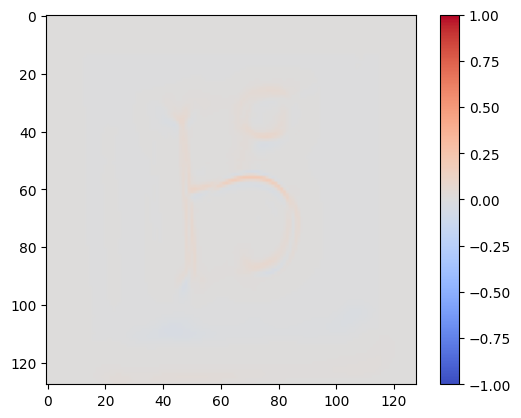

✓ Done


In [22]:
print("Visualization of cluster registration")

plt.figure()
plt.imshow(np.mean(registered_A_subset, axis=0) - np.mean(mapped_B_subset, axis=0), cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
plt.colorbar()
plt.show()
print (u'\u2713', "Done")

You can also browse the images that belong to the cluster in (A) and the registered images belonging to the selected cluster in (B).

In [23]:
widgets.interact(
    display_images,
    imga_stack=widgets.fixed(registered_A_subset),
    imgb_stack=widgets.fixed(mapped_B_subset),
    imga_z=widgets.IntSlider(value=0, min=0, max=registered_A_subset.shape[0] - 1, description=f"Select from group {cluster_chooser_A.value} in (A)", style={'description_width': 'initial'}),
    imgb_z=widgets.IntSlider(value=0, min=0, max=mapped_B_subset.shape[0] - 1, description=f"Select from group {cluster_chooser_B.value} in (A)", style={'description_width': 'initial'}),
    cmap=get_colormap_dropdown('coolwarm')
);

interactive(children=(IntSlider(value=0, description='Select from group 2 in (A)', max=894, style=SliderStyle(…

#### 5.3 Evaluation of cluster distance
Adding to the visual inspection we can calculate similarity/distance/divergence measures between the two selected clusters. At the moment we mostly focus on "*correlation*" as a metric. However, this can be extended in the near future. 

In [24]:
# Make sure that the maps are valid probability distributions
registered_A_subset_norm = registered_A_subset / registered_A_subset.sum(axis=(1,2), keepdims=True)
mapped_B_subset_norm = mapped_B_subset / mapped_B_subset.sum(axis=(1,2), keepdims=True)

In [25]:
# Distance calculation
metric = 'correlation'
dists_A = pdist(registered_A_subset_norm.reshape(registered_A_subset_norm.shape[0], -1), metric=metric)
dists_B = pdist(mapped_B_subset_norm.reshape(mapped_B_subset_norm.shape[0], -1), metric=metric)
dists_AB = cdist(registered_A_subset_norm.reshape(registered_A_subset_norm.shape[0], -1), mapped_B_subset_norm.reshape(mapped_B_subset_norm.shape[0], -1), metric=metric)

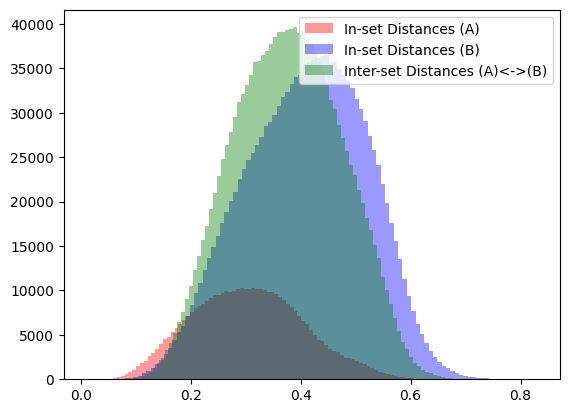

In [26]:
# Histogram comparison
plt.figure()
plt.hist(dists_A, bins=100, color='red', alpha=0.4, label="In-set Distances (A)")
plt.hist(dists_B, bins=100, color='blue', alpha=0.4, label="In-set Distances (B)")
plt.hist(dists_AB.flatten(), bins=100, color='green', alpha=0.4, label="Inter-set Distances (A)<->(B)")
plt.legend()
plt.show()

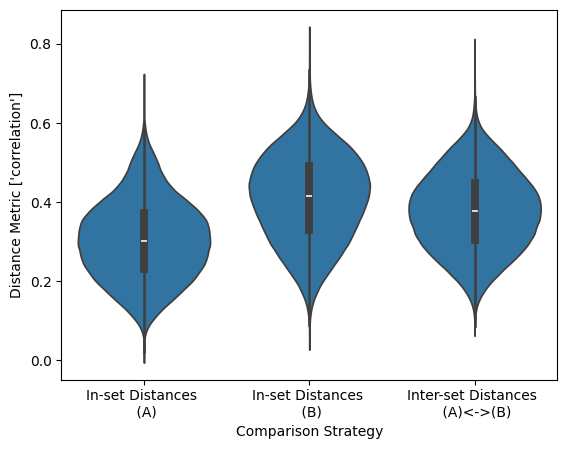

In [27]:
# Comparison of violinplots
df = pd.DataFrame({f"Distance Metric [\'{metric}\']": np.concatenate((dists_A, dists_B, dists_AB.flatten())),
                   'Comparison Strategy': ["In-set Distances \n (A)" for _ in range(len(dists_A))] +
                                          ["In-set Distances \n (B)" for _ in range(len(dists_B))] +
                                          ["Inter-set Distances \n (A)<->(B)" for _ in range(len(dists_AB.flatten()))]})
plt.figure()
sns.violinplot(data=df, x='Comparison Strategy', y=f"Distance Metric [\'{metric}\']")
plt.show()

## 6 Comparison of complete stacks
After analysing different clusters of the image stacks (A) and (B), let's compare both sets on a global level.

#### 6.1 Inter-stack registration and low-dimensional embedding for visualization
Similar to the inter-cluster registration, we must align the image scaling, translation, and rotation between the two stacks. Afterwards, we embed both stacks into low-dimensional spaces and visualize them.

Please now choose a dimensionality reduction technique. Per default, we opt for UMAP. (You can also specify some additional keyword arguments to configure the reduction technique.)
* *UMAP*: https://umap-learn.readthedocs.io/en/latest/
* *T-SNE*: https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html
* *PCA*: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html
* *MDS*: https://scikit-learn.org/dev/modules/generated/sklearn.manifold.MDS.html
* *ISOMAP*: https://scikit-learn.org/dev/modules/generated/sklearn.manifold.Isomap.html

In [28]:
dimreduc_chooser = widgets.Dropdown(options=['umap', 'tsne', 'pca', 'mds', 'isomap'], value='umap', description="Choose dim. reduction method:", style={'description_width': 'initial'})
display(dimreduc_chooser)

Dropdown(description='Choose dim. reduction method:', options=('umap', 'tsne', 'pca', 'mds', 'isomap'), style=…

In [29]:
# Keyword arguments for dimensionality reduction
dimred_config = dict(
    random_state=42
)

In [30]:
print("Inter-stack registration and low-dim. embedding")

print(f"{'(i) Registering stack (B) to stack (A))':.>50}")
sr = StackReg(4)  # 4: Rotation, Translation, Scaling
tmat = sr.register(registered_A.mean(axis=0), registered_B.mean(axis=0))
xb_reg = sr.transform_stack(registered_B, tmats=np.repeat(tmat[None, ...], repeats=len(registered_B), axis=0))

print(f"{'(ii) Low-dim. embedding for visualization':.>50}")
if dimreduc_chooser.value == 'umap':
    dim_op = UMAP
elif dimreduc_chooser.value == 'tsne':
    dim_op = TSNE
elif dimreduc_chooser.value == 'pca':
    dim_op = PCA
elif dimreduc_chooser.value == 'mds':
    dim_op = MDS
elif dimreduc_chooser.value == 'isomap':
    dim_op = Isomap
else:
    raise ValueError("Reduction function not supported.")
xab = np.concatenate((registered_A, xb_reg))
xab_flat = xab.reshape(xab.shape[0], -1)
ld_embedding = dim_op(**dimred_config).fit_transform(xab_flat)
xab_labels = [0 for _ in range(len(registered_A))] + [1 for _ in range(len(xb_reg))]

print (u'\u2713', "Done")

Inter-stack registration and low-dim. embedding
...........(i) Registering stack (B) to stack (A))
.........(ii) Low-dim. embedding for visualization


c:\Users\flori\miniconda3\envs\wdb_skelanalysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done


#### 6.2 Visualization of images as 2D-space embeddings (cluster-agnostic)

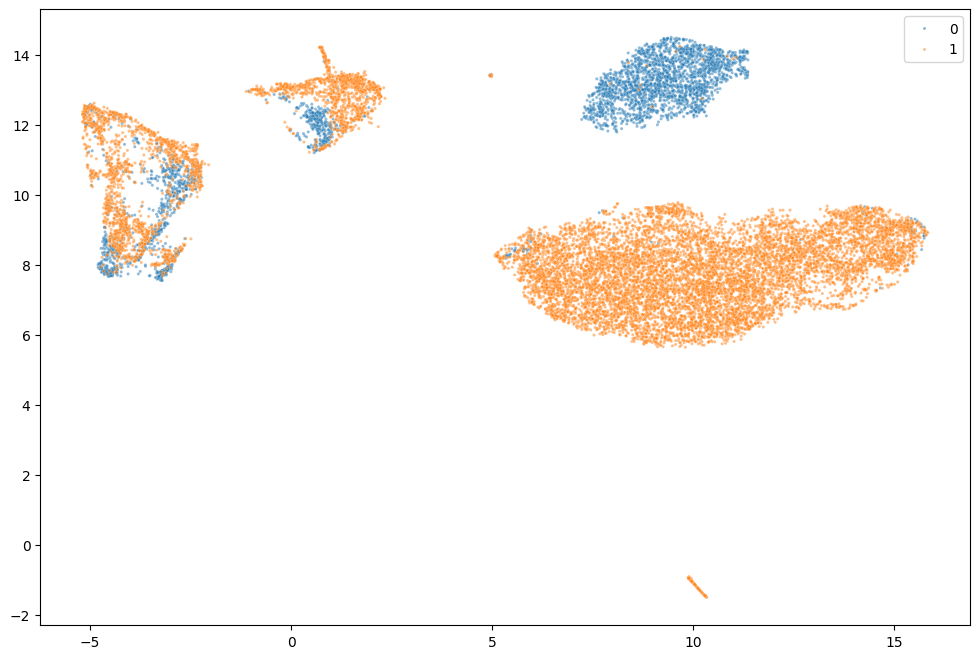

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(ax=ax, x=ld_embedding[:, 0], y=ld_embedding[:, 1], hue=xab_labels, palette=None, s=5.0, alpha=0.5)
plt.show()

#### 6.3 Visualization of images as 2D-space embeddings (cluster-sensitive)

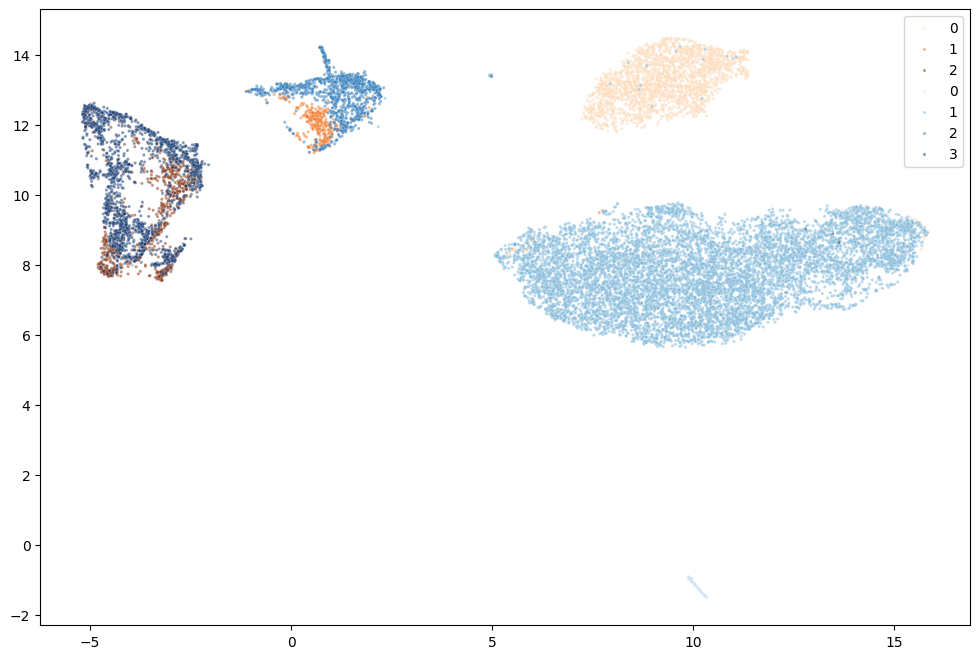

In [35]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap1 = plt.get_cmap('Oranges')
cmap1 = truncate_colormap(cmap1, 0.2, 1)
cmap2 = plt.get_cmap('Blues')
cmap2 = truncate_colormap(cmap2, 0.2, 1)

kwargs = dict(
    s= 5.0, 
    alpha= 0.5
)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
sns.scatterplot(ax=ax, x=ld_embedding[:len(registered_A), 0], y=ld_embedding[:len(registered_A), 1], hue=cluster_labels_A, palette=cmap1, **kwargs)
sns.scatterplot(ax=ax, x=ld_embedding[len(registered_A):, 0], y=ld_embedding[len(registered_A):, 1], hue=cluster_labels_B, palette=cmap2, **kwargs)
plt.show()

#### 6.4 Visualization of images as 2D-space embeddings (cluster-sensitive & interactive)

In [36]:
%autoreload 2

interactive_cluster_visualization(registered_A, xb_reg, ld_embedding[:len(registered_A)], ld_embedding[len(registered_A):], cluster_labels_A, cluster_labels_B, sample_size = 500, max_img_size=(128, 128))

    'da…

## EXPERIMENTAL

In [39]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import ot

In [40]:
f1 = clusters_A[0][0]
f2 = clusters_A[1][0]

f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
A = np.array([f1, f2])

nb_images = 10

v1 = np.array((1, 0))
v2 = np.array((0, 1))

Progress: 0/10
Progress: 1/10
Progress: 2/10
Progress: 3/10
Progress: 4/10
Progress: 5/10
Progress: 6/10
Progress: 7/10
Progress: 8/10
Progress: 9/10


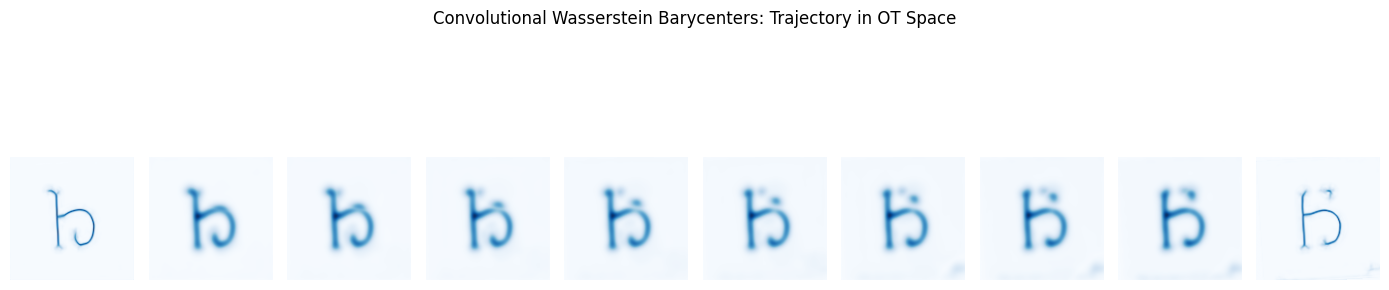

In [41]:
fig, axes = plt.subplots(1, nb_images, figsize=(14, 4))
plt.suptitle('Convolutional Wasserstein Barycenters: Trajectory in OT Space')
cm = 'Blues'
reg = 0.001 # regularization parameter

for i in range(nb_images):
    print(f"Progress: {i}/{nb_images}")
    tx = float(i) / (nb_images - 1)    
    weights = (1 - tx) * v1 + tx * v2 # weights are constructed by bilinear interpolation

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        # call to barycenter computation
        axes[i].imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
####
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import pdist, squareform
import umap

# Distance calculation
metric = 'correlation'
print("A")
dists_A = pdist(registered_A_subset_norm.reshape(registered_A_subset_norm.shape[0], -1), metric=wasserstein_distance)
print("B")
dists_B = pdist(mapped_B_subset_norm.reshape(mapped_B_subset_norm.shape[0], -1), metric=wasserstein_distance)
#print("3")
#dists_AB = cdist(registered_A_subset_norm.reshape(registered_A_subset_norm.shape[0], -1), mapped_B_subset_norm.reshape(mapped_B_subset_norm.shape[0], -1), metric=wasserstein_distance)
dists_A_sq = squareform(dists_A)
dists_B_sq = squareform(dists_B)
#dists_AB_sq = squareform(dists_AB)

distance_matrix = np.concatenate((dists_A_sq, dists_B_sq))

# UMAP for embedding into 2D space using the precomputer square distance matrix
ws_embedding = umap.UMAP(metric='precomputed').fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(ws_embedding[:len(dists_A), 0], ws_embedding[:len(dists_A), 1], c='red', s=50, label="(A)")
plt.scatter(ws_embedding[len(dists_A):(len(dists_a) + len(dists_B)), 0], ws_embedding[len(dists_A):(len(dists_a) + len(dists_B)), 1], c='blue', s=50, label="(B)")
plt.scatter(ws_embedding[(len(dists_a) + len(dists_B)):, 0], ws_embedding[(len(dists_a) + len(dists_B)):, 1], c='green', s=50, label="(A)-(B)")
plt.title('UMAP Embedding of Probability Maps with Wasserstein Distance')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
distance_matrix = np.concatenate((dists_A_sq, dists_B_sq))

# UMAP for embedding into 2D space using the precomputer square distance matrix
ws_embedding = umap.UMAP(metric='precomputed').fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(ws_embedding[:len(dists_A), 0], ws_embedding[:len(dists_A), 1], c='red', s=50, label="(A)")
plt.scatter(ws_embedding[len(dists_A):(len(dists_a) + len(dists_B)), 0], ws_embedding[len(dists_A):(len(dists_a) + len(dists_B)), 1], c='blue', s=50, label="(B)")
# plt.scatter(ws_embedding[(len(dists_a) + len(dists_B)):, 0], ws_embedding[(len(dists_a) + len(dists_B)):, 1], c='green', s=50, label="(A)-(B)")
plt.title('UMAP Embedding of Probability Maps with Wasserstein Distance')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()